# 5.8.1 Sampling and Reconstruction of Lowpass Signals
<span style="color:red"> <b>*Note: text on p.345-346 skipped*</b></span>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
# On kaggle, one can add new data folders by clicking the uploading sign next to the "Add Data" button on the right hand side panel.
# We can upload a new dataset name such as "chapter05images". The input path /kaggle/input/chapter05images

In [2]:
def sampandquant(sig_in, L, td, ts):
    """
    Usage:
    s_out, sq_out, sqh_out, Delta, SQNR = sampandquant(sig_in, L, td, ts)
    L - number of uniform quantization levels
    sig_in - input signal vector
    td - original signal sampling period of sig_in
    ts - new sampling period
    NOTE: td*fs must be a positive integer;
    Function outputs:
    s_out - sampled output
    sq_out - sample-and-quantized output
    sqh_out - sample,quantize, and hold output
    Delta - quantization interval
    SQNR - actual signal to quantization noise ratio
    """
    if (ts/td).is_integer():
        nfac = int(np.round(ts/td))
        p_zoh = np.ones(nfac)
        s_out = sig_in[::nfac]
        sq_out, Delta, SQNR = uniquan(s_out, L)
        s_out = np.stack([s_out] +[s_out*0] * (nfac-1),axis=-1).reshape(-1)
        sqh_out = np.kron(sq_out, p_zoh)
    else:
        print("Errors! ts/td is not an integer!")
        s_out = sq_out = sqh_out = Delta = SQNR = []
    return s_out, sq_out, sqh_out, Delta, SQNR

def uniquan(sig_in, L):
    """
    Usage:
    q_out, Delta, SQNR = uniquan(sig_in, L)
    L - number of uniform quantization levels
    sig_in - input signal vector
    Function outputs:
    q_out - quantized output
    Delta - quantization interval
    SQNR - actual signal to quantization noise ratio
    """
    sig_pmax = np.max(sig_in)   # finding the positive peak
    sig_nmax = np.min(sig_in)   # finding the negative peak
    Delta = (sig_pmax - sig_nmax) / L    # quantization interval
    q_level = np.arange(sig_nmax + Delta / 2, sig_pmax - Delta / 2 + Delta, Delta)  # define Q-levels
    L_sig = len(sig_in)   # find signal length
    sigp = (sig_in - sig_nmax) / Delta + 1/2   # convert into 1/2 to L+1/2 range
    qindex = np.round(sigp).astype(int)     # round to 1,2, ... L levels
    qindex[qindex < 1] = 1
    qindex[qindex > L] = L   # eliminate L+1 as a rare possibility
    q_out = q_level[qindex - 1]  # use index vector to generate output
    SQNR = 20*np.log10(np.linalg.norm(sig_in)/np.linalg.norm(sig_in-q_out))  # actual SQNR value
    return q_out, Delta, SQNR

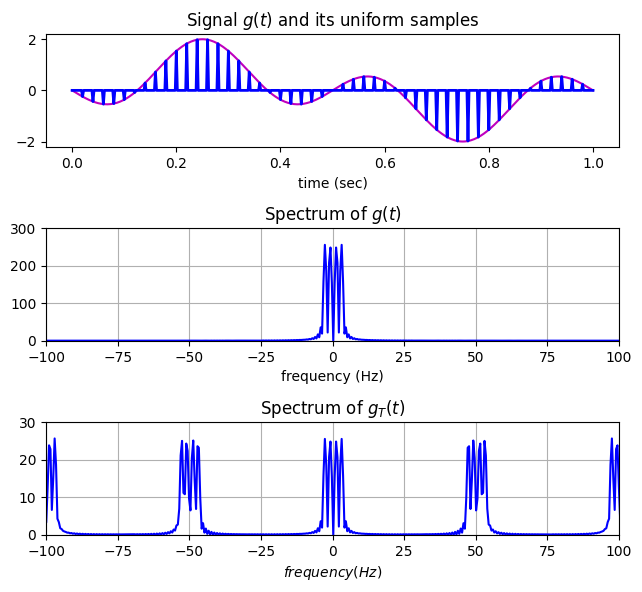

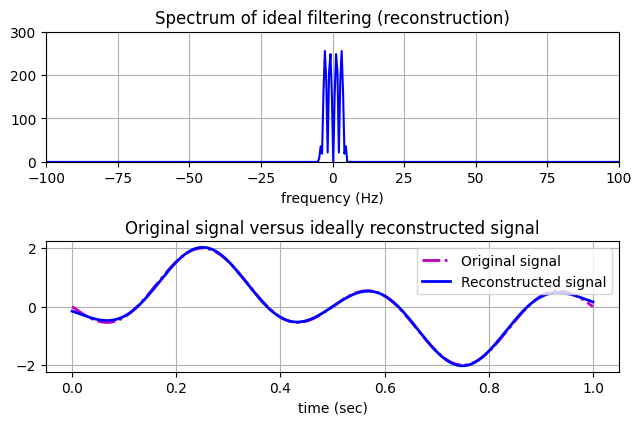

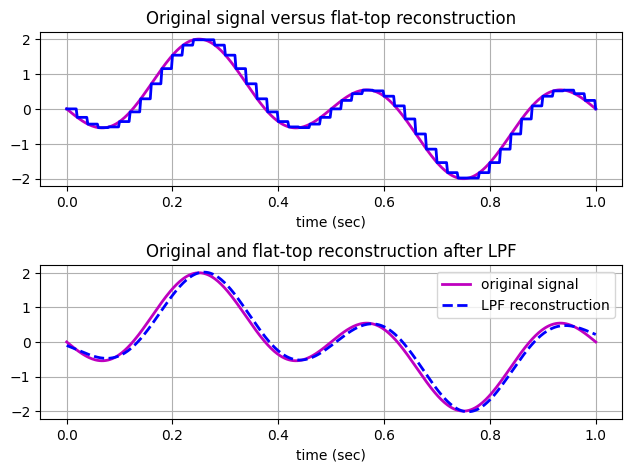

In [3]:
# Save this codeblock as ExSample.py
td = 0.002  #original sampling rate 500 Hz
t = np.arange(0, 1+td, td)  # Time interval of 1 second
xsig = np.sin(2*np.pi*t)-np.sin(6*np.pi*t) # 1Hz+3Hz sinusoids
Lsig = len(xsig)

ts = 0.02 #new sampling rate = 50Hz.
Nfactor = int(ts/td)
# send the signal through a 16-level uniform quantizer
s_out, sq_out, sqh_out, Delta, SQNR = sampandquant(xsig, 16, td, ts)

# receive 3 signals:
#   1. sampled signal s_out
#   2. sampled and quantized signal sq_out
#   3. sampled, quantized, and zero-order hold signal sqh_out
# calculate the Fourier transforms
Lfft = 2**int(np.ceil(np.log2(Lsig)+1))
Fmax = 1/(2*td)
Faxis = np.linspace(-Fmax, Fmax, Lfft)
Xsig = np.fft.fftshift(np.fft.fft(xsig, Lfft))
S_out = np.fft.fftshift(np.fft.fft(s_out, Lfft))

# Examples of sampling and reconstruction using
#   a) ideal impulse train through LPF
#   b) flat top pulse reconstruction through LPF
# plot the original signal and the sample signals in time and frequency domain
fig1 = plt.figure(figsize=(6.5,6)); fig1.subplots_adjust(hspace=0.5,wspace=0.4)
plt.subplot(311); 
sfig1a = plt.plot(t,xsig,'m',linewidth=1.5)
sfig1b = plt.plot(t,s_out[:Lsig],'b',linewidth=2)
plt.xlabel('time (sec)')
plt.title(r'Signal ${\it g}({\it t})$ and its uniform samples')

plt.subplot(312); sfig1c = plt.plot(Faxis,np.abs(Xsig),'b',linewidth=1.5)
plt.xlabel(r'frequency (Hz)'); plt.axis([-100, 100, 0, 300])
plt.title(r'Spectrum of ${\it g}({\it t})$'); plt.grid()

plt.subplot(313); sfig1d = plt.plot(Faxis,np.abs(S_out),'b',linewidth=1.5)
plt.xlabel(r'$frequency (Hz)$'); plt.axis([-100, 100, 0, 300/Nfactor])
plt.title(r'Spectrum of ${\it g}_T({\it t})$'); plt.grid()
# Set the spacing between subfigures
plt.tight_layout(pad=1.0);  plt.show()

# calculate the reconstructed signal from ideal sampling and ideal LPF
# Maximum LPF bandwidth equals to BW = floor((Lfft/Nfactor)/2);
BW = 10 # Bandwidth is no larger than 10Hz.
H_lpf = np.zeros(Lfft)
H_lpf[int(Lfft/2)-BW:int(Lfft/2)+BW] = 1 # ideal LPF
S_recv = Nfactor*S_out*H_lpf # ideal filtering
s_recv = np.real(np.fft.ifft(np.fft.fftshift(S_recv))) # reconstructed f-domain
s_recv = s_recv[:Lsig]

# non-ideal reconstruction
ZOH = np.ones(Nfactor)
s_ni = np.kron(s_out[::Nfactor], ZOH)
S_ni = np.fft.fftshift(np.fft.fft(s_ni, Lfft))
S_recv2 = S_ni*H_lpf # ideal filtering
s_recv2 = np.real(np.fft.ifft(np.fft.fftshift(S_recv2))) # reconstructed f-domain
s_recv2 = s_recv2[:Lsig] # reconstructed t-domain

# plot the ideally reconstructed signal in time and frequency domain
fig2 = plt.figure(figsize=(6.5,6)); fig2.subplots_adjust(hspace=0.5,wspace=0.4)
plt.subplot(311);  sfig2a = plt.plot(Faxis,np.abs(S_recv),'b',linewidth=1.5)
plt.xlabel('frequency (Hz)'); plt.axis([-100, 100, 0, 300]); plt.grid()
plt.title('Spectrum of ideal filtering (reconstruction)')

plt.subplot(312); sfig2b = plt.plot(t,xsig,'m-.',t,s_recv[:Lsig],'b',linewidth=2)
plt.legend(['Original signal','Reconstructed signal'])
plt.xlabel('time (sec)'); plt.grid()
plt.title('Original signal versus ideally reconstructed signal')
# Set the spacing between subfigures
plt.tight_layout(pad=1.0); plt.show()

# plot the ideally reconstructed signal in time and frequency domain
fig3 = plt.figure(); fig3.subplots_adjust(hspace=0.5,wspace=0.4)
plt.subplot(211); sfig3a = plt.plot(t,xsig,'m',t,s_ni[:Lsig],'b',linewidth=2)
plt.xlabel('time (sec)'); plt.grid()
plt.title('Original signal versus flat-top reconstruction')

plt.subplot(212); sfig3b = plt.plot(t,xsig,'m',t,s_recv2[:Lsig],'b--',linewidth=2)
plt.legend(['original signal','LPF reconstruction'])
plt.xlabel('time (sec)'); plt.grid()
plt.title('Original and flat-top reconstruction after LPF')
# Set the spacing between subfigures
plt.tight_layout(pad=1.0); plt.show()

<img src="images/Fig5_41.png" width="600" />

<center><b>Figure 5.41</b> The relationship between the original signal and the ideal uniformly sampled signal in the time (a) and frequency (b, c) domains.</center>

<img src="images/Fig5_42.png" width="600" />

<center><b>Figure 5.42</b> Reconstructed signal spectrum and waveform from applying the ideal impulse sampling and ideal LPF reconstruction. </center>

<img src="images/Fig5_43.png" width="600" />

<center><b>Figure 5.43</b> Reconstructed signal spectrum and waveform from applying the simple rectangular reconstruction pulse (Fig. 5.6) followed by LPF without equalization.  </center>


# 5.8.2 PCM Illustration
<span style="color:red"> <b>*Note: text on pps.348-350 skipped*</b></span>


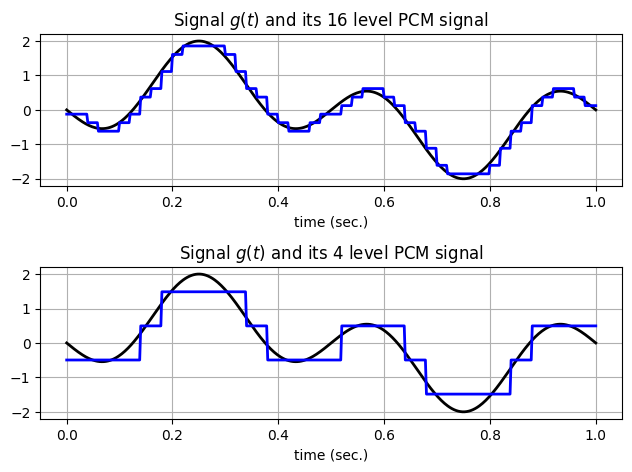

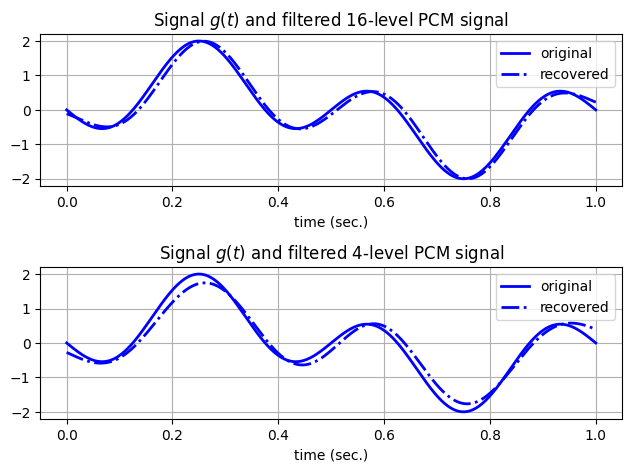

In [4]:
# Save the following code block as ExPCM.py
td = 0.002  # original sampling rate 500 Hz
t = np.arange(0, 1 + td, td)  # time interval of 1 second
xsig = np.sin(2 * np.pi * t) - np.sin(6 * np.pi * t)  # 1Hz+3Hz sinusoids
Lsig = len(xsig)
Lfft = int(2 ** (np.ceil(np.log2(Lsig)) + 1))
Xsig = np.fft.fftshift(np.fft.fft(xsig, Lfft))
Fmax = 1 / (2 * td)
Faxis = np.linspace(-Fmax, Fmax, Lfft)
ts = 0.02  # new sampling rate = 50Hz.
Nfact = int(ts / td)
# send the signal through a 16-level uniform quantizer
(s_out, sq_out, sqh_out1, Delta, SQNR) = sampandquant(xsig, 16, td, ts)
# obtained the PCM signal which is
# - sampled, quantized, and zero-order hold signal sqh_out

# plot the original signal and the PCM signal in time domain
fig1 = plt.figure()
fig1.subplots_adjust(hspace=0.5,wspace=0.4)

plt.subplot(211)
sfig1 = plt.plot(t,xsig,'k',t,sqh_out1[:Lsig],'b',linewidth=2)
plt.title(r'Signal ${\it g}({\it t})$ and its 16 level PCM signal')
plt.xlabel('time (sec.)'); plt.grid()

# send the signal through a 4-level uniform quantizer
(s_out, sq_out, sqh_out2, Delta, SQNR) = sampandquant(xsig, 4, td, ts)
# obtained the PCM signal which is
# - sampled, quantized, and zero-order hold signal sqh_out
# plot the original signal and the PCM signal in time domain 
plt.subplot(212)
sfig2 = plt.plot(t,xsig,'k',t,sqh_out2[:Lsig],'b',linewidth=2)
plt.title(r'Signal ${\it g}({\it t})$ and its 4 level PCM signal')
plt.xlabel('time (sec.)'); plt.grid()
# Set the spacing between subfigures
plt.tight_layout(pad=1.0); plt.show()

Lfft = int(2 ** (np.ceil(np.log2(Lsig)) + 1))
Fmax = 1 / (2 * td)
Faxis = np.linspace(-Fmax, Fmax, Lfft)
SQH1 = np.fft.fftshift(np.fft.fft(sqh_out1, Lfft))
SQH2 = np.fft.fftshift(np.fft.fft(sqh_out2, Lfft))
# Now use LPF to filter the two PCM signals
BW = 10
# Bandwidth is no larger than 10Hz.
H_lpf = np.zeros(Lfft)
H_lpf[Lfft // 2 - BW:Lfft // 2 + BW] = 1  # ideal LPF
S1_recv = SQH1 * H_lpf  # ideal filtering
s_recv1 = np.real(np.fft.ifft(np.fft.fftshift(S1_recv)))  # reconstructed f-domain
s_recv1 = s_recv1[:Lsig]  # reconstructed t-domain
S2_recv = SQH2 * H_lpf  # ideal filtering
s_recv2 = np.real(np.fft.ifft(np.fft.fftshift(S2_recv)))  # reconstructed f-domain
s_recv2 = s_recv2[:Lsig]  # reconstructed t-domain

# Plot the filtered signals against the original signal
fig2 = plt.figure()
fig2.subplots_adjust(hspace=0.5,wspace=0.4)

plt.subplot(211)
sfig3 = plt.plot(t,xsig,'b-',t,s_recv1,'b-.',linewidth=2)
plt.legend(['original','recovered'])
plt.title(r'Signal ${\it g}({\it t})$ and filtered 16-level PCM signal')
plt.xlabel('time (sec.)'); plt.grid()

plt.subplot(212)
sfig4 = plt.plot(t,xsig,'b-',t,s_recv2[:Lsig],'b-.',linewidth=2)
plt.legend(['original','recovered'])
plt.title(r'Signal ${\it g}({\it t})$ and filtered 4-level PCM signal')
plt.xlabel('time (sec.)'); plt.grid()
# Set the spacing between subfigures
plt.tight_layout(pad=1.0); plt.show()

<img src="images/Fig5_44.png" width="600" />

<center><b>Figure 5.44</b> Original signal and the PCM signals with different numbers of quantization levels.</center>

<img src="images/Fig5_45.png" width="600" />

<center><b>Figure 5.45</b> Comparison between the original signal and the PCM signals after LPF to recover the original message.</center>


# 5.8.3 Delta Modulation


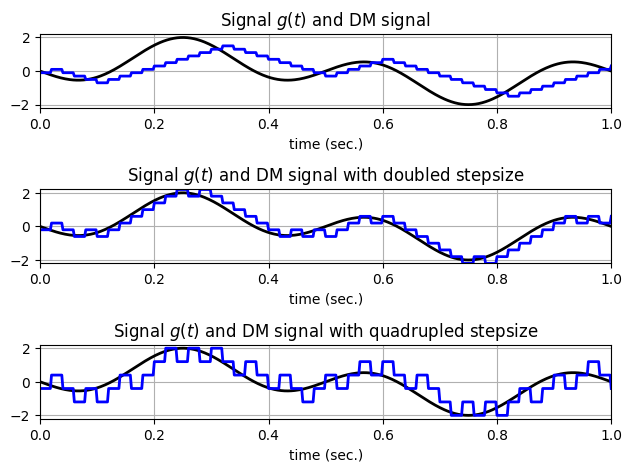

In [5]:
# Example of sampling, quantization, and zero-order hold
def deltamod(sig_in, Delta, td, ts):
    # Delta - DM stepsize
    # sig_in - input signal vector
    # td - original signal sampling period of sig_in
    # ts - new sampling period
    # NOTE: td*fs must be a positive integer;
    # Function outputs:
    # s_DMout - DM sampled output
    if not ts/td % 1 == 0:
        print("Error! ts/td is not an integer!")
        return []
    nfac = round(ts/td)
    p_zoh = np.ones(nfac)
    s_down = sig_in[::nfac]
    Num_it = len(s_down)
    s_DMout = np.zeros(Num_it+1)
    s_DMout[0] = -Delta/2
    for k in range(1, Num_it+1):
        xvar = s_DMout[k-1]
        s_DMout[k] = xvar + Delta*np.sign(s_down[k-1]-xvar)
    s_DMout = np.kron(s_DMout, p_zoh)
    return s_DMout

# Save the block below as ExDM.py
td = 0.002 # original sampling rate 500 Hz
t = np.arange(0, 1+td, td) # time interval of 1 second
xsig = np.sin(2*np.pi*t) - np.sin(6*np.pi*t) # 1Hz+3Hz sinusoids
Lsig = len(xsig)
ts = 0.02 # new sampling rate = 50Hz
Nfact = ts/td
# send the signal through a 16-level uniform quantizer
Delta1 = 0.2 # First select a small Delta=0.2 in DM
s_DMout1 = deltamod(xsig, Delta1, td, ts)
# obtained the DM signal 
# plot the original signal and the DM signal in time domain
fig1 = plt.figure()
fig1.subplots_adjust(hspace=0.5,wspace=0.4)

plt.subplot(311)
sfig1 = plt.plot(t,xsig,'k',t,s_DMout1[:Lsig],'b',linewidth=2)
plt.title(r'Signal ${\it g}({\it t})$ and DM signal')
plt.xlabel('time (sec.)'); plt.axis([0, 1, -2.2, 2.2]); plt.grid()

# Apply DM again by doubling the Delta 
Delta2 = 2*Delta1
s_DMout2 = deltamod(xsig, Delta2, td, ts)
# obtained the DM signal
# plot the original signal and the DM signal in time domain
plt.subplot(312)
sfig2 = plt.plot(t,xsig,'k',t,s_DMout2[:Lsig],'b',linewidth=2)
plt.title(r'Signal ${\it g}({\it t})$ and DM signal with doubled stepsize')
plt.xlabel('time (sec.)'); plt.axis([0, 1, -2.2, 2.2]); plt.grid()

Delta3 = 2*Delta2 # Double the DM Delta again.
s_DMout3 = deltamod(xsig, Delta3, td, ts)
# plot the original signal and the DM signal in time domain
plt.subplot(313)
sfig3 = plt.plot(t,xsig,'k',t,s_DMout3[:Lsig],'b',linewidth=2)
plt.title(r'Signal ${\it g}({\it t})$ and DM signal with quadrupled stepsize')
plt.xlabel('time (sec.)'); plt.axis([0, 1, -2.2, 2.2]); plt.grid()
# Set the spacing between subfigures
plt.tight_layout(pad=1.0); plt.show()

<img src="images/Fig5_46.png" width="600" />

<center><b>Figure 5.46</b> Examples of delta modulation output with three different step sizes: (a) small step size leads to overloading; (b) reasonable step size; (c) large step size causes large quantization errors.</center>

# 5.8.4 Video Residual Image Compression and Coding

<img src="images/Fig5_47.png" width="600" />

<center><b>Figure 5.47</b> Computer exercise example.</center>

In [6]:
# Save the following block as a block DCT function  block_dct8_normq.py
def bloc_dct8_normq(imgbloc, Qpk):
    # Input = imgbloc (8x8 original input image block for encoding)
    # Output = qdimg (8x8 decoded image block)
    # Typical 8x8 Q_matrix entered:

    Q_matrix = np.array([[16,11,10,16,26,40,51,61],
                         [12,12,14,19,26,58,60,55],
                         [14,13,16,24,40,57,69,56],
                         [14,17,22,29,51,87,80,62],
                         [18,22,37,56,68,109,103,77],
                         [24,35,55,64,81,104,113,92],
                         [49,64,78,87,103,121,120,101],
                         [72,92,95,98,112,100,103,99]])
    dctbloc = dct(dct(imgbloc.T, norm='ortho').T, norm='ortho') # Take DCT2 of imageblock
    Dyn = Q_matrix * Qpk # Dynamic Q-matrix scaled by Qpk
    qdct = np.round(dctbloc / Dyn) # Element-wise quantization (index)
    iqdct = qdct * Dyn # denormalization
    qdimg = np.round(idct(idct(iqdct.T, norm='ortho').T, norm='ortho')) # inverse DCT
    return qdimg

In the following example, we tested the famous "cameraman.tiff" image and selected three different values for the encoder
parameter *Qpk*. Specifically, we tested *Qpk* =1, 4, and 8, respectively.  The three resulting images of descending
qualities are shown in comparison with the original uncompressed image. 

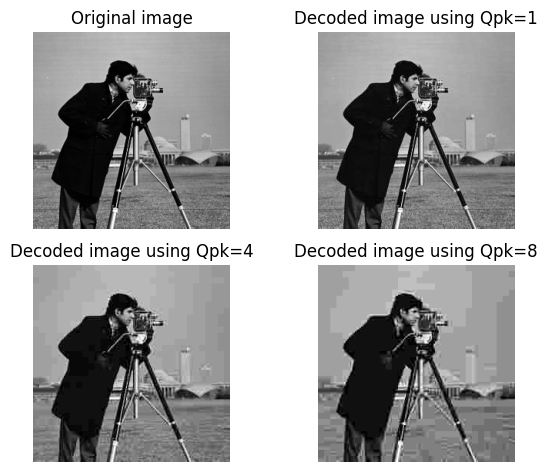

In [11]:
# Save the codeblock below as EXDCTencoding.py
# This example performs 8x8 based DCT2 on an image file whose size is a multiple of 8x8 pixels. 
# By applying different Qpk values, the trade-off of rate and quality can be shown. Higher Qpk 
# leads to lower rate (i.e. higher compression rate) and lower quality
# Load the cameraman image from Kaggle dataset
import os
data_dirbook='/kaggle/input/chapter05images' 
G = plt.imread(os.path.join(data_dirbook,'cameraman.tiff'))
# OR you can use G = plt.imread('/kaggle/input/chapter05images/cameraman.tiff')
img = np.array(G)

# Display the original image
plt.subplot(221); plt.imshow(img, cmap='gray')
plt.axis('off'); plt.title('Original image')

# Perform 8x8 DCT compression with Qpk=1
Qpk = 1
qimg1 = np.zeros_like(img)
for i in range(0, img.shape[0], 8):
    for j in range(0, img.shape[1], 8):
        block = img[i:i+8, j:j+8]
        qblock = bloc_dct8_normq(block,Qpk=1)
        qblock = np.clip(qblock, 0, 255)
        qimg1[i:i+8, j:j+8] = qblock
# Recover the compressed image to [0, 255]
qimg1 = np.clip(qimg1, 0, 255)
# Display the decoded image using Qpk=1
plt.subplot(222); plt.imshow(qimg1, cmap='gray')
plt.axis('off');plt.title('Decoded image using Qpk=1')

# Perform 8x8 DCT compression with Qpk=4
Qpk = 4
qimg2 = np.zeros_like(img)
for i in range(0, img.shape[0], 8):
    for j in range(0, img.shape[1], 8):
        block = img[i:i+8, j:j+8]
        qblock = bloc_dct8_normq(block,Qpk=4)
        qblock = np.clip(qblock, 0, 255)
        qimg2[i:i+8, j:j+8] = qblock
# Recover the compressed image to [0, 255]
qimg2 = np.clip(qimg2, 0, 255)
# Display the decoded image using Qpk=4
plt.subplot(223); plt.imshow(qimg2, cmap='gray')
plt.axis('off');plt.title('Decoded image using Qpk=4')

# Perform 8x8 DCT compression with Qpk=8
Qpk = 8
qimg3 = np.zeros_like(img)
for i in range(0, img.shape[0], 8):
    for j in range(0, img.shape[1], 8):
        block = img[i:i+8, j:j+8]
        qblock = bloc_dct8_normq(block,Qpk=8)
        qblock = np.clip(qblock, 0, 255)
        qimg3[i:i+8, j:j+8] = qblock
# Recover the compressed image to [0, 255]
qimg3 = np.clip(qimg3, 0, 255)

# Display the decoded image using Qpk=8
plt.subplot(224); plt.imshow(qimg3, cmap='gray')
plt.axis('off'); plt.title('Decoded image using Qpk=8')
plt.tight_layout(pad=1.0)  # Set the spacing between subfigures